In [1]:
import numpy as np
from lineflow.simulation import (
    Source,
    Sink,
    Line,
    Assembly,
)
from lineflow.examples import (
    WaitingTime,
    ComplexLine,
    WaterLine
)
from matplotlib import pyplot as plt

pygame 2.6.1 (SDL 2.28.4, Python 3.9.21)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
def make_optimal_agent(line):

    waiting_times = line['S_component'].state['waiting_time'].categories
    processing_time_source = line['S_component'].processing_time

    def agent(state, env):
        """
        A policy that can effectively set float waiting times by
        alternating between ints
        """
        time_assembly = state['Assembly']['processing_time'].value + 1 + 1 + 1.1
        time_source = processing_time_source*1.1 + 1.1
        waiting_time = time_assembly - time_source

        index = np.argmin(np.abs(waiting_times - waiting_time))
        actions = {}
        actions['S_component'] = {'waiting_time': index}
        return actions
    return agent


In [3]:
line = WaitingTime(use_rates=True,
            use_normalization=True,
            step_size=1)
agent = make_optimal_agent(line)
# line.run(simulation_end=4000, agent=agent, visualize = False)
all_states, state_names, action_stations, all_actions, rewards, reward_cumulative = line.run(simulation_end=4000, agent=agent, record_states=True, visualize = False)
print(line.get_n_parts_produced())

99.98%|█████████████████████████████████████████████████▉|

Original Reward Sum: 157
Test Reward Sum: 5245.25
uptime: 0.63603125
158


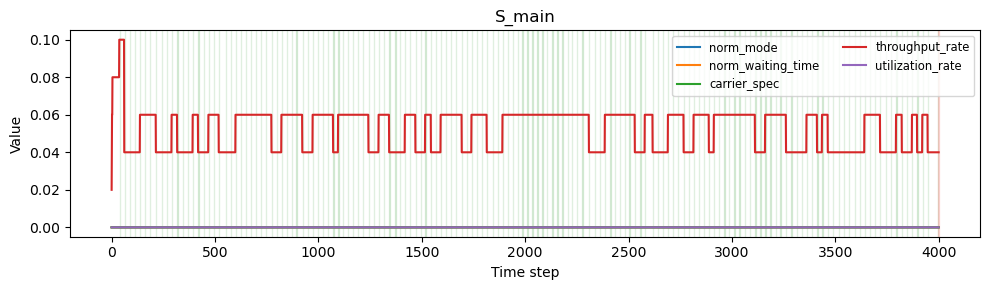

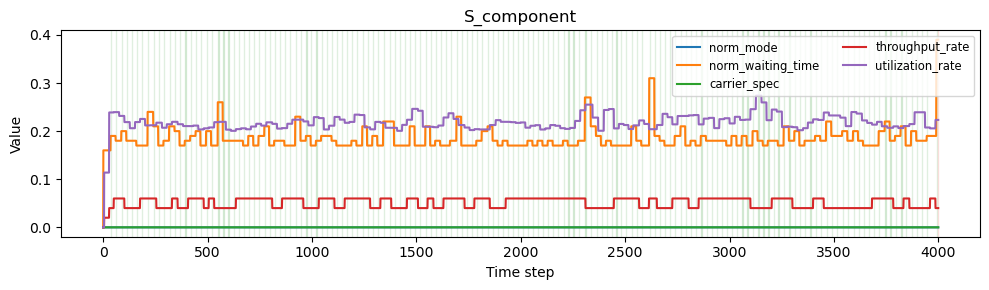

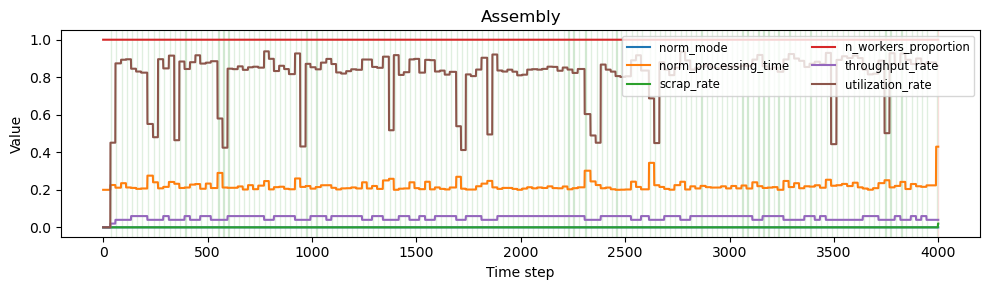

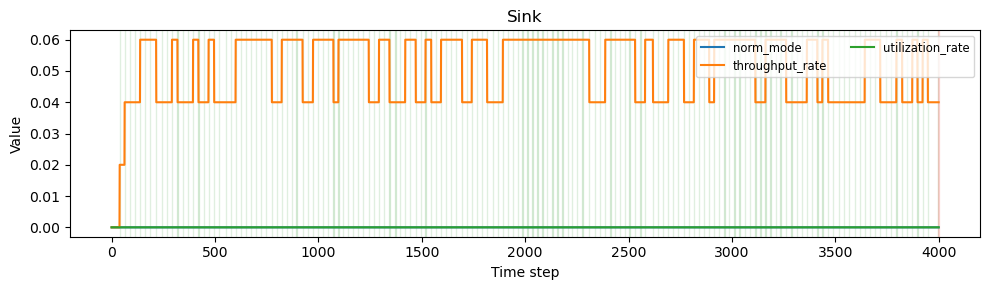

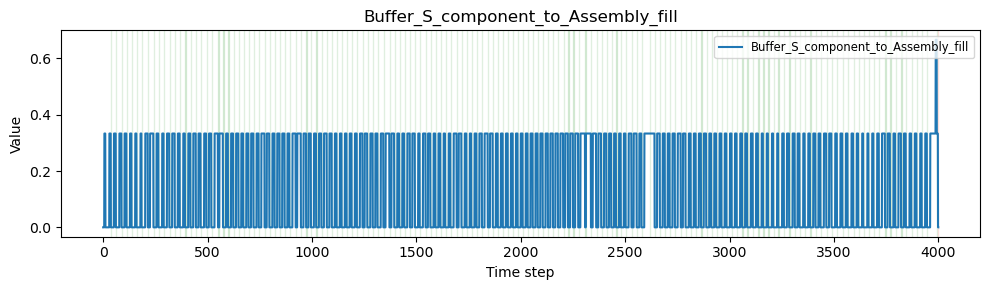

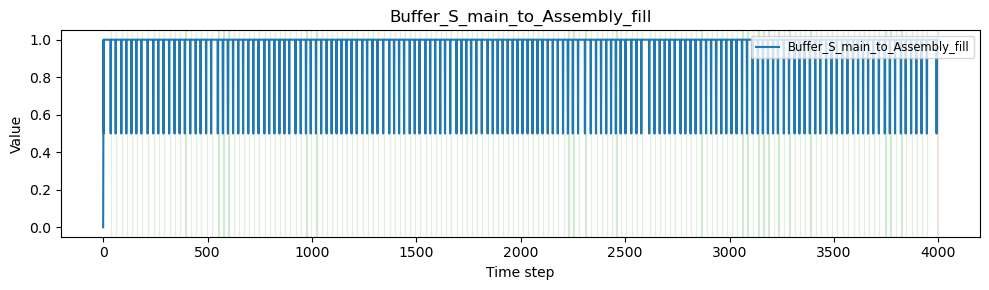

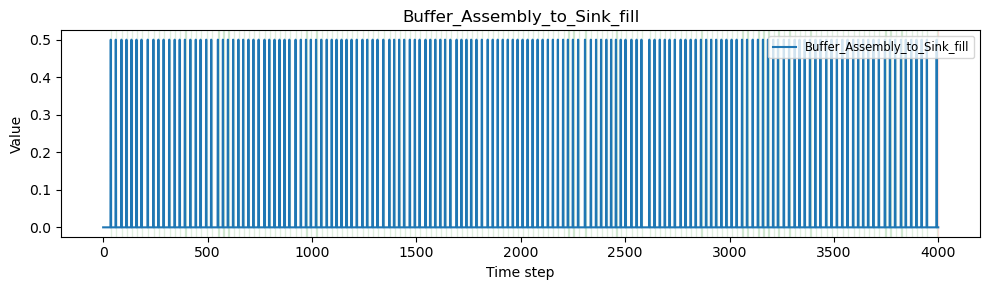

In [4]:
# Group state dimensions by station and plot each station's variables together
# Monkey-patch plt.plot to add reward-colored background (green=positive, red=negative, white=zero)
_orig_plot = plt.plot

def _plot_with_reward_background(*args, **kwargs):
    ax = plt.gca()
    if not hasattr(ax, '_reward_background_done'):
        rewards_arr = np.asarray(rewards)
        n_steps = len(rewards_arr)
        for t, r in enumerate(rewards_arr):
            if r > 0:
                ax.axvspan(t - 0.5, t + 0.5, color='green', alpha=0.12, zorder=0)
            elif r < 0:
                ax.axvspan(t - 0.5, t + 0.5, color='red', alpha=0.12, zorder=0)
        ax._reward_background_done = True
    return _orig_plot(*args, **kwargs)

plt.plot = _plot_with_reward_background
station_indices = {}
states_arr = np.array(all_states)
for idx, n in enumerate(state_names):
    if n.startswith('Buffer_'):
        station = n  # each buffer on its own (single metric)
    else:
        parts = n.split('_')
        if parts[0] == 'S' and len(parts) > 1:
            station = '_'.join(parts[:2])  # S_main, S_component
        else:
            station = parts[0]  # Assembly, Sink
    station_indices.setdefault(station, []).append((idx, n))

for station, items in station_indices.items():
    plt.figure(figsize=(10, 3))
    for idx, full_name in items:
        label = full_name if station == full_name else full_name[len(station)+1:]
        plt.plot(states_arr[:, idx], label=label)
    plt.title(station)
    plt.xlabel('Time step')
    plt.ylabel('Value')
    plt.legend(loc='upper right', fontsize='small', ncol=2)
    plt.tight_layout()
    plt.show()



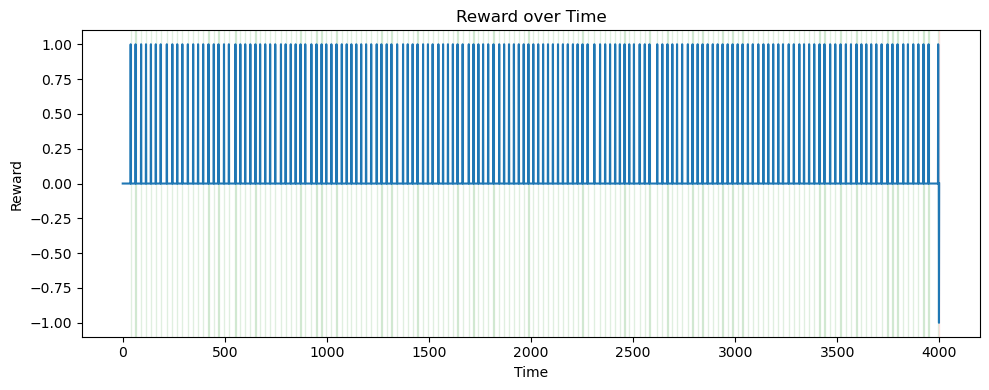

In [8]:
plt.plot(rewards)
plt.xlabel('Time')
plt.ylabel('Reward')
plt.title('Reward over Time')
plt.gcf().set_size_inches(10, 4)
plt.tight_layout()
plt.show()

In [2]:
def make_agent_random_waiting_time(line):
    waiting_times = line['S_component'].state['waiting_time'].categories

    def agent(state, env):
        """
        A policy that selects a random waiting time index
        """
        index = np.random.choice(len(waiting_times))
        actions = {}
        actions['S_component'] = {'waiting_time': index}
        return actions
    return agent


In [3]:
line = WaitingTime(use_rates=True,
            use_normalization=True,
            step_size=10)
agent = make_agent_random_waiting_time(line)
# line.run(simulation_end=4000, agent=agent, visualize = False)
all_states, state_names, action_stations, all_actions, rewards, reward_cumulative = line.run(simulation_end=4000,record_states=True, agent=agent, visualize = False)
print(line.get_n_parts_produced())

99.75%|█████████████████████████████████████████████████▉|

Original Reward Sum: 69
Test Reward Sum: 518.25
uptime: 0.5615625
71


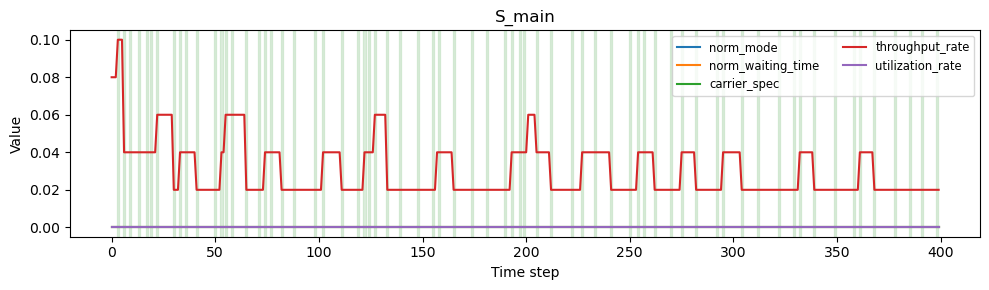

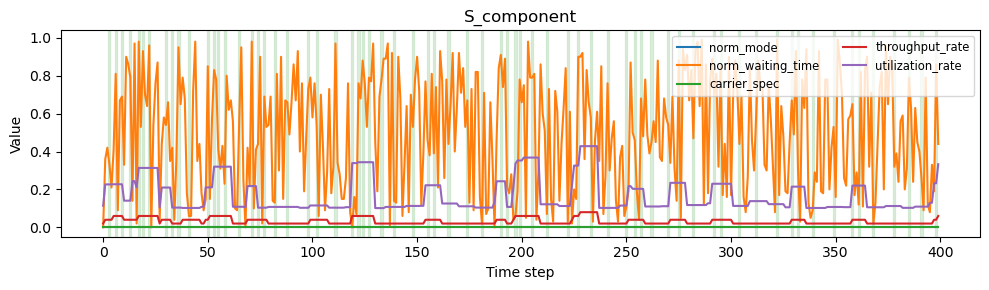

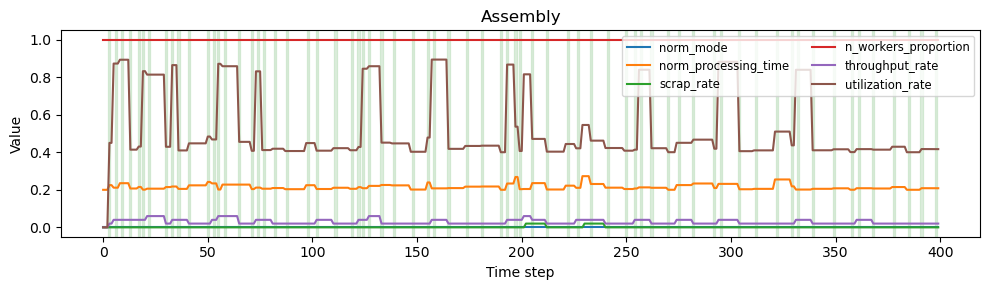

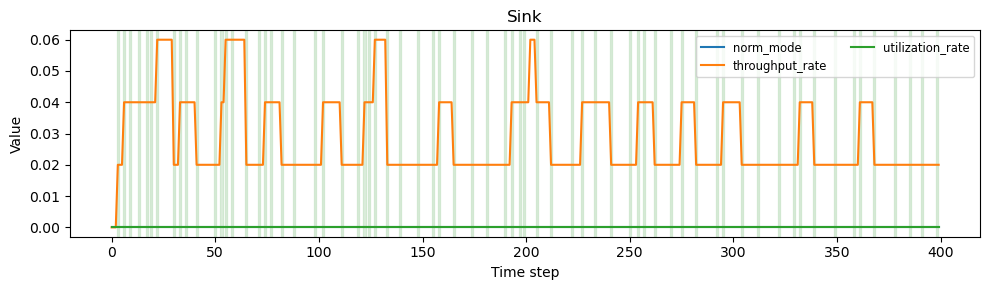

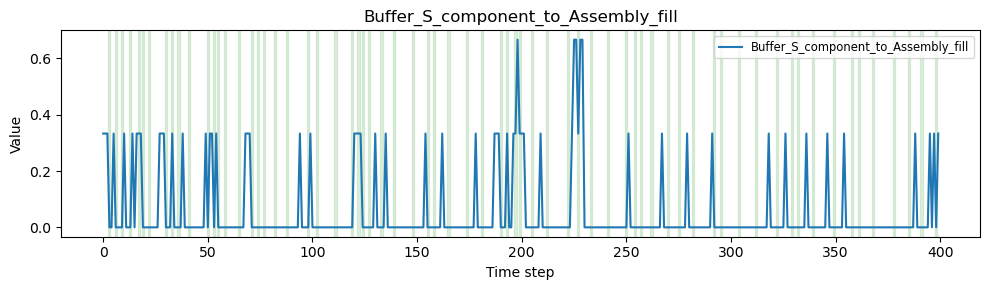

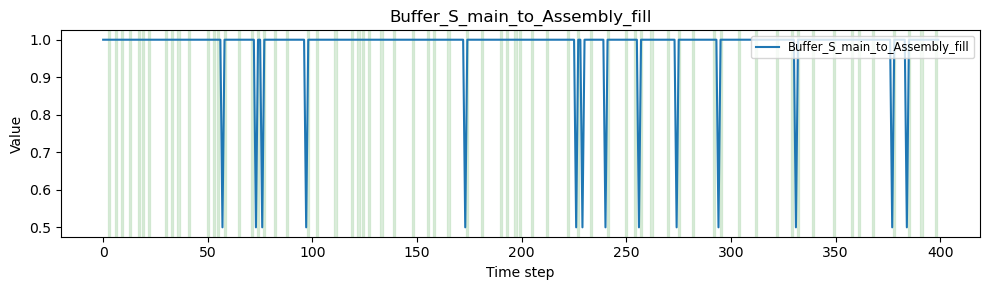

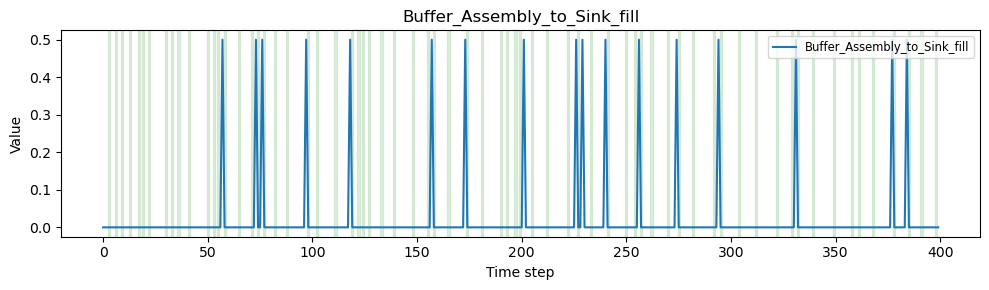

In [4]:
# Group state dimensions by station and plot each station's variables together
# Monkey-patch plt.plot to add reward-colored background (green=positive, red=negative, white=zero)
_orig_plot = plt.plot

def _plot_with_reward_background(*args, **kwargs):
    ax = plt.gca()
    if not hasattr(ax, '_reward_background_done'):
        rewards_arr = np.asarray(rewards)
        n_steps = len(rewards_arr)
        for t, r in enumerate(rewards_arr):
            if r > 0:
                ax.axvspan(t - 0.5, t + 0.5, color='green', alpha=0.12, zorder=0)
            elif r < 0:
                ax.axvspan(t - 0.5, t + 0.5, color='red', alpha=0.12, zorder=0)
        ax._reward_background_done = True
    return _orig_plot(*args, **kwargs)

plt.plot = _plot_with_reward_background
station_indices = {}
states_arr = np.array(all_states)
for idx, n in enumerate(state_names):
    if n.startswith('Buffer_'):
        station = n  # each buffer on its own (single metric)
    else:
        parts = n.split('_')
        if parts[0] == 'S' and len(parts) > 1:
            station = '_'.join(parts[:2])  # S_main, S_component
        else:
            station = parts[0]  # Assembly, Sink
    station_indices.setdefault(station, []).append((idx, n))

for station, items in station_indices.items():
    plt.figure(figsize=(10, 3))
    for idx, full_name in items:
        label = full_name if station == full_name else full_name[len(station)+1:]
        plt.plot(states_arr[:, idx], label=label)
    plt.title(station)
    plt.xlabel('Time step')
    plt.ylabel('Value')
    plt.legend(loc='upper right', fontsize='small', ncol=2)
    plt.tight_layout()
    plt.show()



In [2]:
from lineflow.examples.complex_line import make_agent
import time

In [ ]:
ramp_up_waiting_time = 10
waiting_time = 5
n_assemblies = 5
n_workers = 3*n_assemblies
scrap_factor = 1/n_assemblies
step_size =1
line = ComplexLine(
    realtime=False,
    factor=0.05,
    alternate=False,
    n_assemblies=n_assemblies,
    n_workers=n_workers,
    step_size=step_size,
    scrap_factor=scrap_factor,
    random_state=0,
    assembly_condition=30,
    use_graph_as_states=False, # test graph,
    use_rates=True,
    use_normalization=True
)

agent = make_agent(
    state=line.state,
    ramp_up_waiting_time=ramp_up_waiting_time,
    waiting_time=waiting_time,
    n_assemblies=n_assemblies,
    n_workers=n_workers,
    get_max_reward=False
    )
start = time.time()
# line.run(simulation_end=4000, agent=agent, capture_screen=False, show_status=True, visualize=False)
all_states, state_names, action_stations, all_actions, rewards, reward_cumulative = line.run(simulation_end=4000, agent=agent, record_states=True, visualize = False)
# collected_data = line.run(simulation_end=4000, agent=agent, capture_screen=False, show_status=True, visualize=False,
#         collect_data=True # test graph
#         )
end = time.time()
print("Produced: ", line.get_n_parts_produced())
print("Scrap: ", line.get_n_scrap_parts())
print("Reward: ",  line.get_n_parts_produced() - line.get_n_scrap_parts()*scrap_factor)
print("Time taken: ", end - start)

0.00%|                                                  |

99.98%|█████████████████████████████████████████████████▉|

Original Reward Sum: 223.4000000000002
Test Reward Sum: 4412.511111111164
uptime: 0.5236388888888966
Produced:  232
Scrap:  43
Reward:  223.4
Time taken:  6.015613079071045


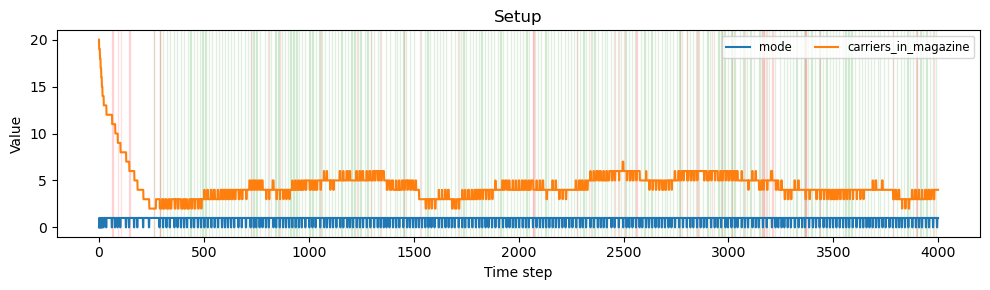

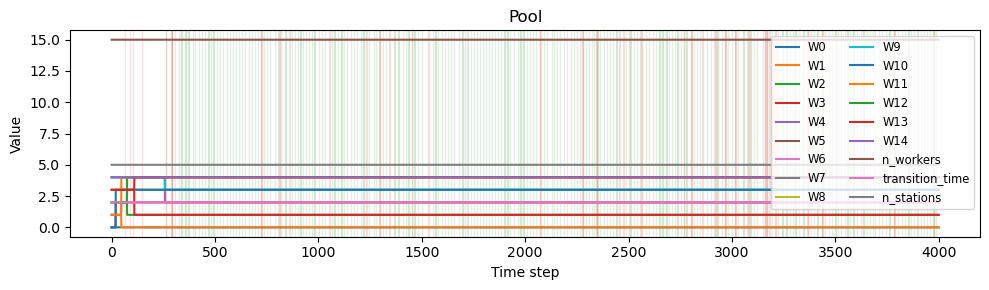

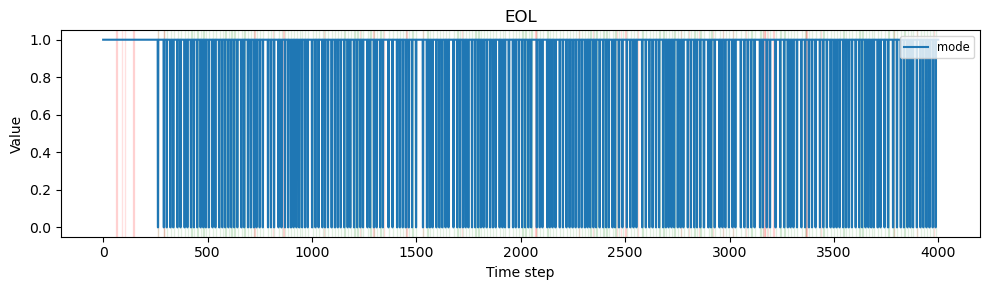

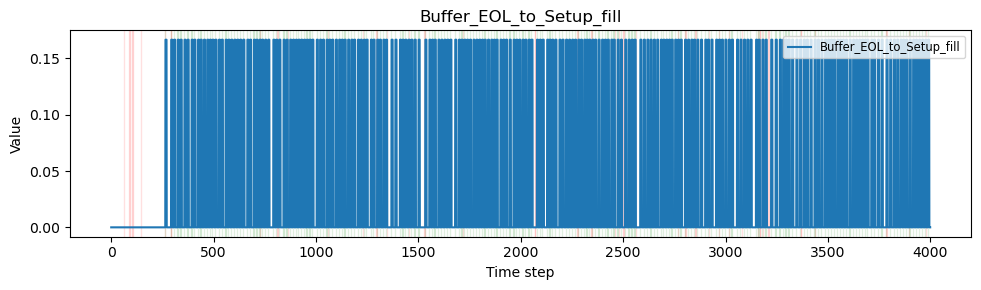

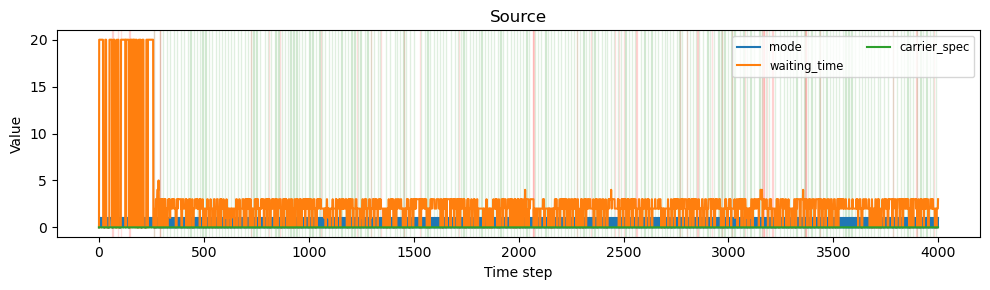

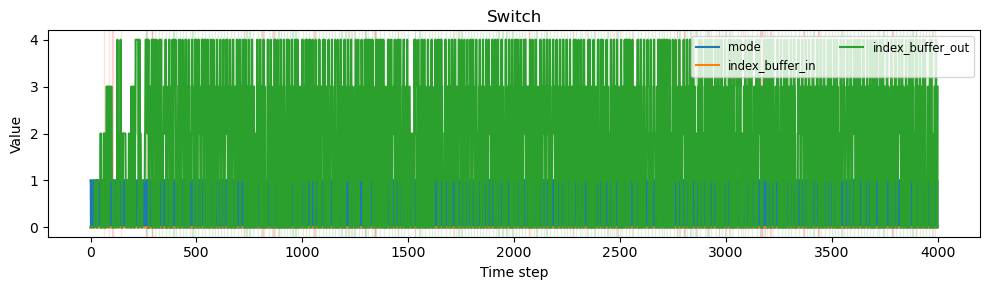

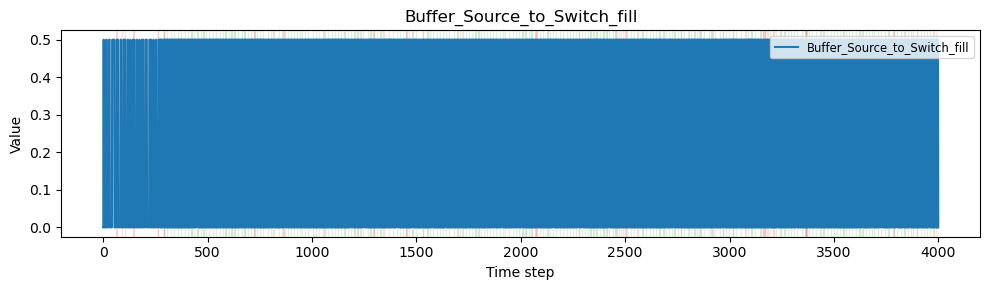

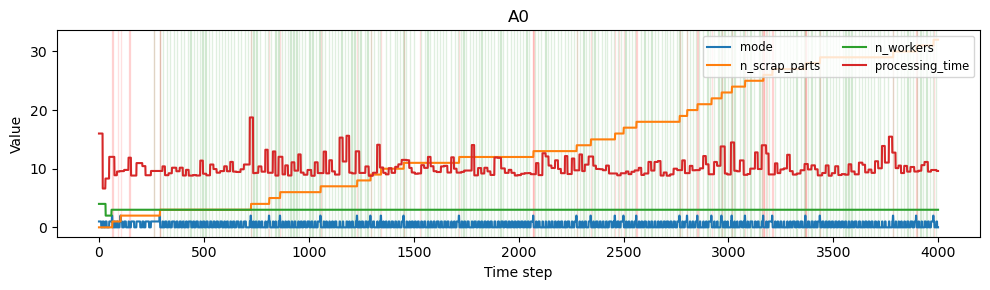

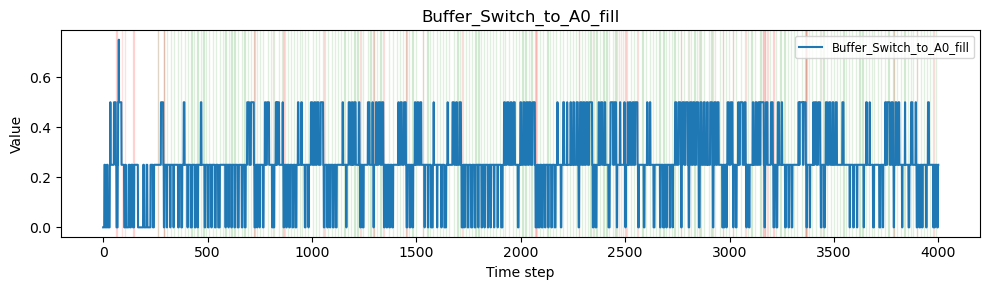

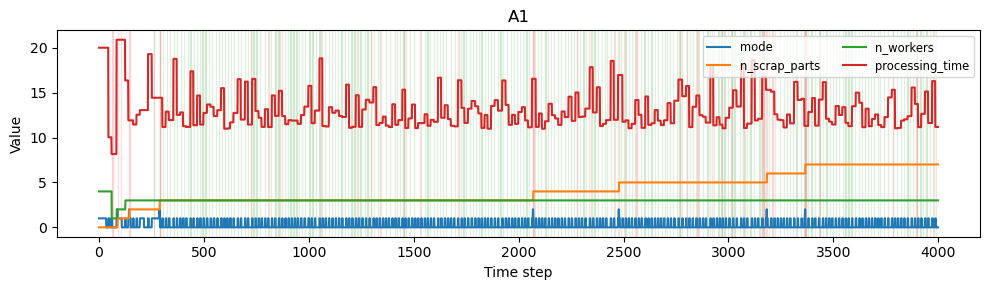

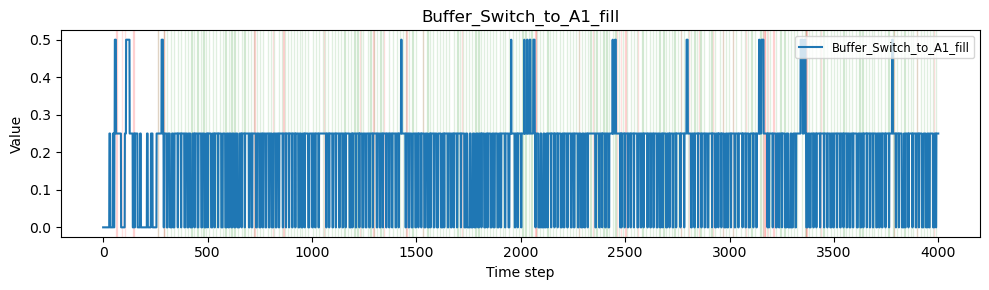

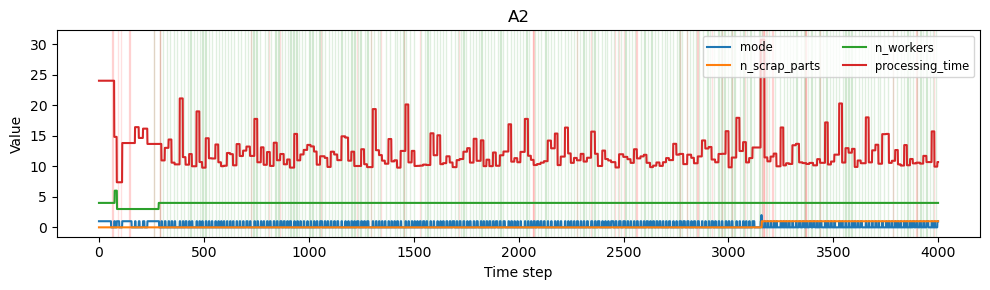

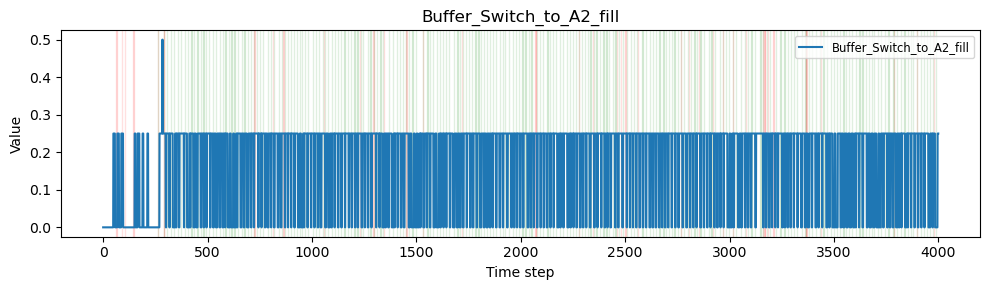

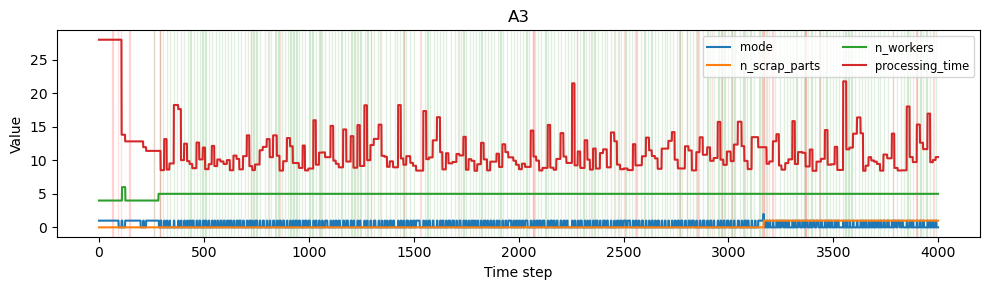

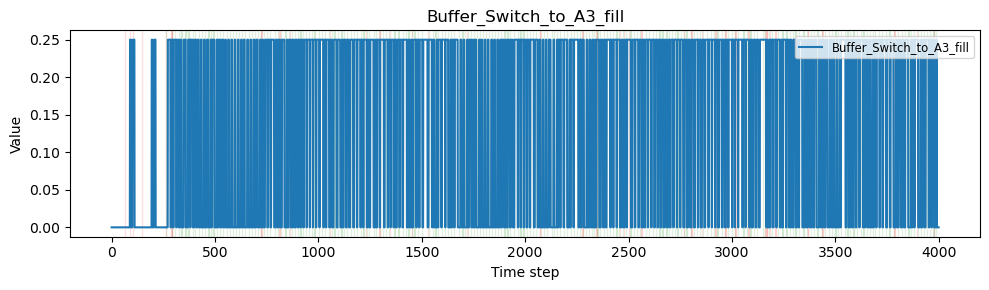

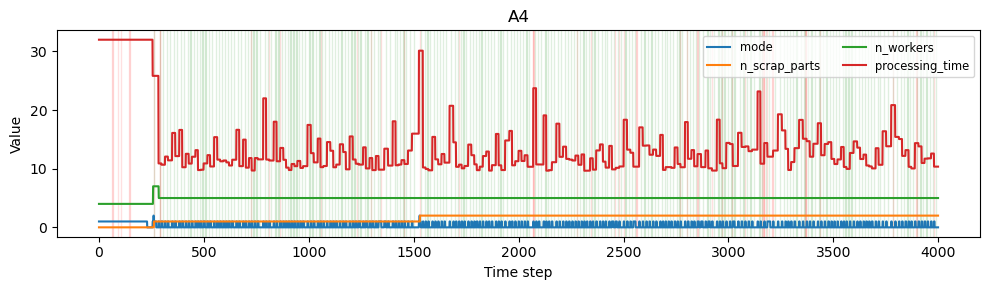

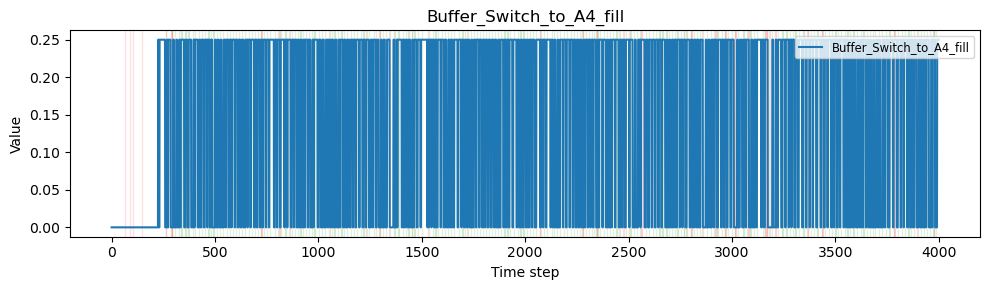

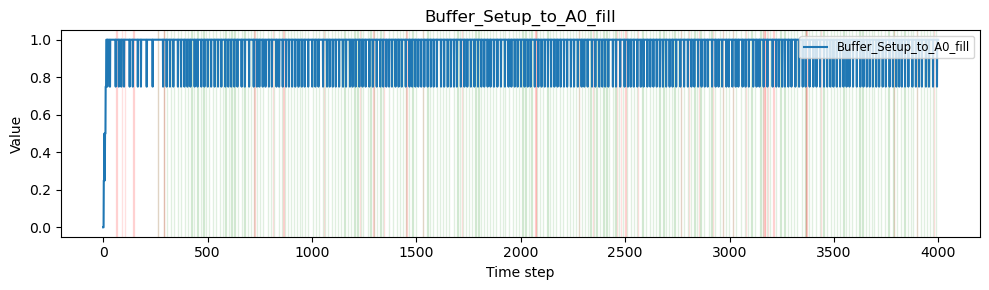

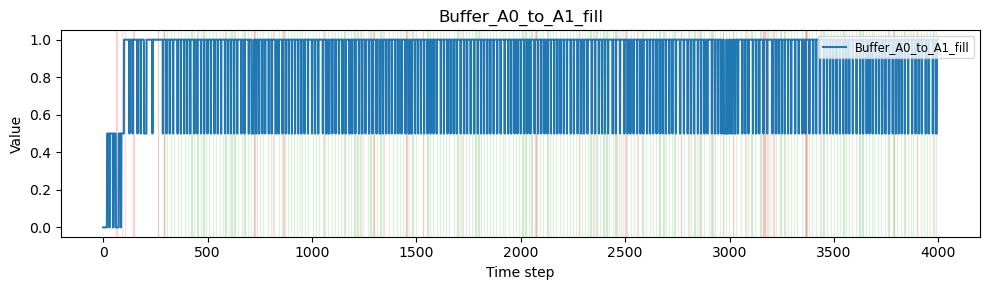

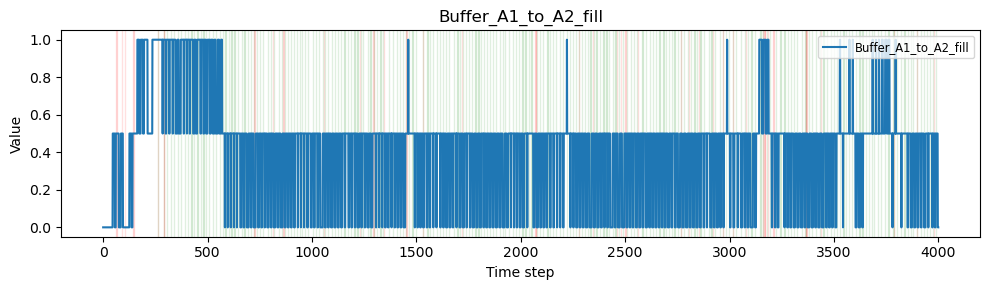

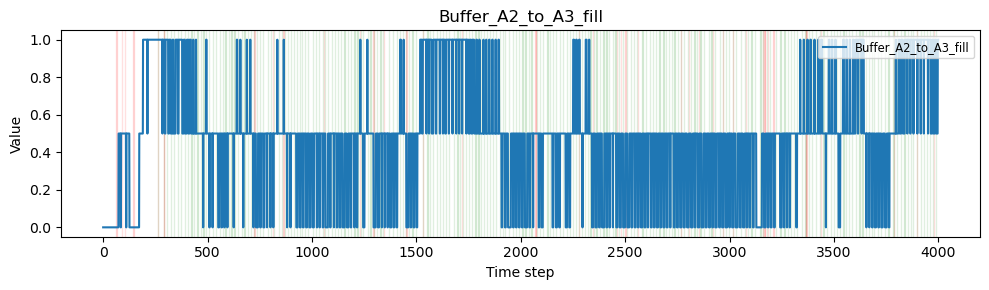

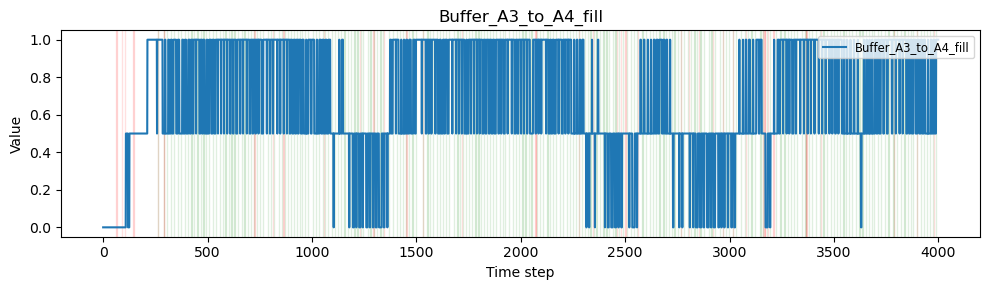

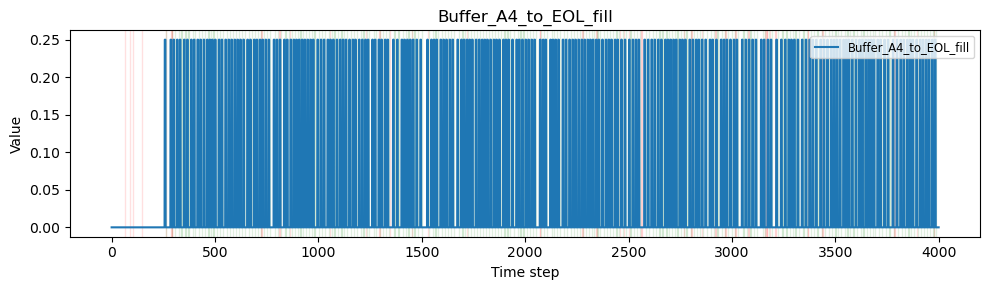

In [4]:
import os

# Group state dimensions by station and plot each station's variables together
# Monkey-patch plt.plot to add reward-colored background (green=positive, red=negative, white=zero)
# Directory to save plots
plots_dir = "plots_complex_line"
os.makedirs(plots_dir, exist_ok=True)

# Counter for filenames
_plot_save_idx = 0

# Save-on-show monkey patch
_orig_show = plt.show
def _show_and_save(*args, **kwargs):
    global _plot_save_idx
    fig = plt.gcf()
    fig.savefig(os.path.join(plots_dir, f"plot_{_plot_save_idx:03d}.png"),
                dpi=150, bbox_inches='tight')
    _plot_save_idx += 1
    return _orig_show(*args, **kwargs)
plt.show = _show_and_save

# Keep original plot (used later in custom wrapper)
_orig_plot = plt.plot

def _plot_with_reward_background(*args, **kwargs):
    ax = plt.gca()
    if not hasattr(ax, '_reward_background_done'):
        rewards_arr = np.asarray(rewards)
        n_steps = len(rewards_arr)
        for t, r in enumerate(rewards_arr):
            if r > 0:
                ax.axvspan(t - 0.5, t + 0.5, color='green', alpha=0.12, zorder=0)
            elif r < 0:
                ax.axvspan(t - 0.5, t + 0.5, color='red', alpha=0.12, zorder=0)
        ax._reward_background_done = True
    return _orig_plot(*args, **kwargs)

plt.plot = _plot_with_reward_background
station_indices = {}
states_arr = np.array(all_states)
for idx, n in enumerate(state_names):
    if n.startswith('Buffer_'):
        station = n  # each buffer on its own (single metric)
    else:
        parts = n.split('_')
        if parts[0] == 'S' and len(parts) > 1:
            station = '_'.join(parts[:2])  # S_main, S_component
        else:
            station = parts[0]  # Assembly, Sink
    station_indices.setdefault(station, []).append((idx, n))

for station, items in station_indices.items():
    plt.figure(figsize=(10, 3))
    for idx, full_name in items:
        label = full_name if station == full_name else full_name[len(station)+1:]
        plt.plot(states_arr[:, idx], label=label)
    plt.title(station)
    plt.xlabel('Time step')
    plt.ylabel('Value')
    plt.legend(loc='upper right', fontsize='small', ncol=2)
    plt.tight_layout()
    plt.show()



In [2]:
import random
import time
def make_random_agent(state, n_assemblies, n_workers):

    def agent(state, env):
        actions = {}

        # Random worker assignment
        worker_names = [worker.name for worker in state.get_actions()["Pool"]]
        worker_assignment = np.random.randint(0, n_assemblies, size=len(worker_names))
        actions['Pool'] = dict(zip(worker_names, worker_assignment))

        # Random switch action
        actions['Switch'] = {'index_buffer_out': random.randint(0, n_assemblies - 1)}

        # Random source waiting time
        waiting_times = state['Source']['waiting_time'].categories
        actions['Source'] = {'waiting_time': random.randint(0, len(waiting_times) - 1)}

        return actions

    return agent

In [3]:
ramp_up_waiting_time = 10
waiting_time = 5
n_assemblies = 5
n_workers = 3*n_assemblies
scrap_factor = 1/n_assemblies
step_size =1
line = ComplexLine(
    realtime=False,
    factor=0.05,
    alternate=False,
    n_assemblies=n_assemblies,
    n_workers=n_workers,
    step_size=step_size,
    scrap_factor=scrap_factor,
    random_state=0,
    assembly_condition=30,
    use_graph_as_states=False, # test graph,
    use_rates=True,
    use_normalization=True
)

agent = make_random_agent(state=line.state, n_assemblies=n_assemblies, n_workers=n_workers)
start = time.time()
# line.run(simulation_end=4000, agent=agent, capture_screen=False, show_status=True, visualize=False)
all_states, state_names, action_stations, all_actions, rewards, reward_cumulative = line.run(simulation_end=4000, agent=agent, record_states=True, visualize = False)
# collected_data = line.run(simulation_end=4000, agent=agent, capture_screen=False, show_status=True, visualize=False,
#         collect_data=True # test graph
#         )
end = time.time()
print("Produced: ", line.get_n_parts_produced())
print("Scrap: ", line.get_n_scrap_parts())
print("Reward: ",  line.get_n_parts_produced() - line.get_n_scrap_parts()*scrap_factor)
print("Time taken: ", end - start)

99.98%|█████████████████████████████████████████████████▉|

Original Reward Sum: -2.4000000000000017
Test Reward Sum: 4088.711111111179
uptime: 0.5113888888888973
Produced:  5
Scrap:  37
Reward:  -2.4000000000000004
Time taken:  5.778506278991699


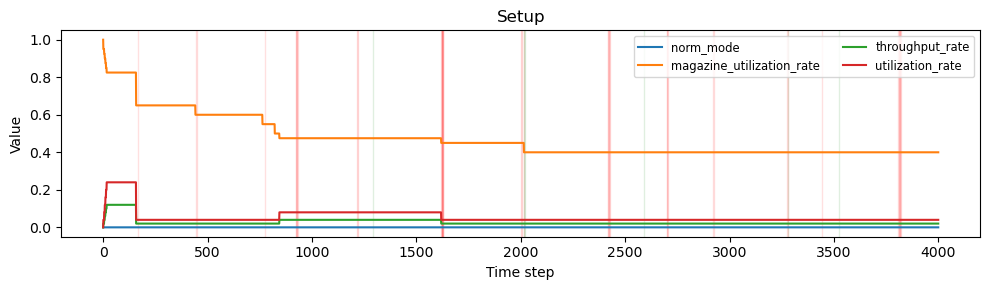

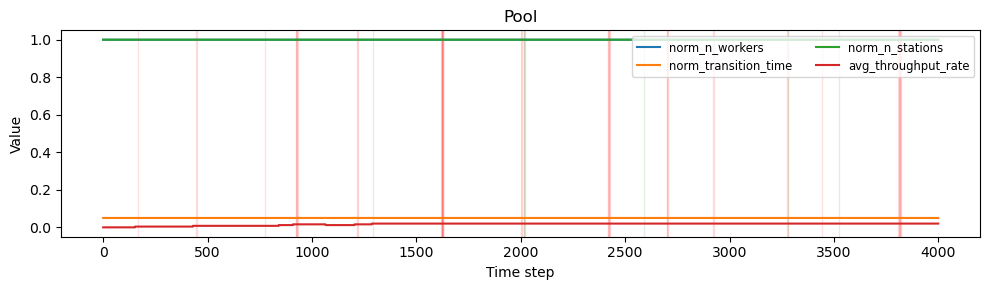

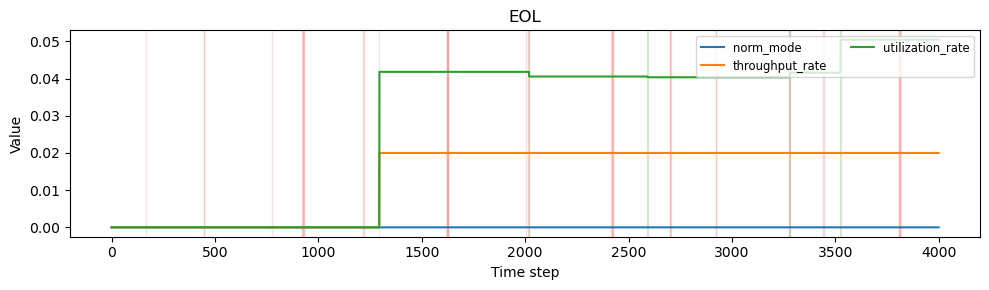

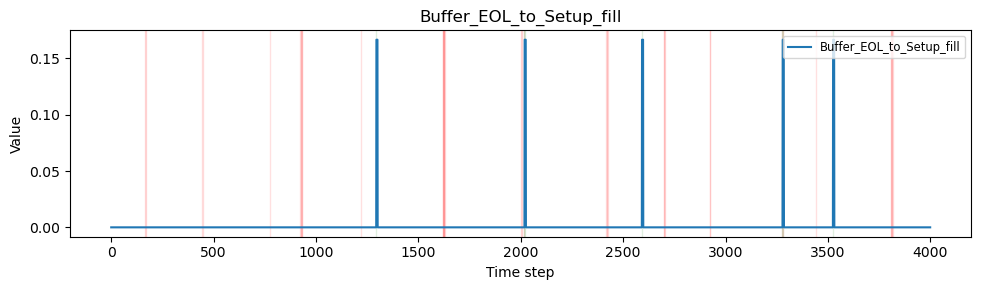

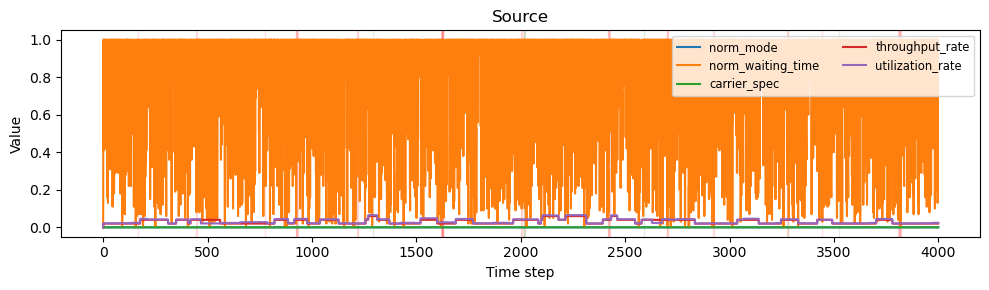

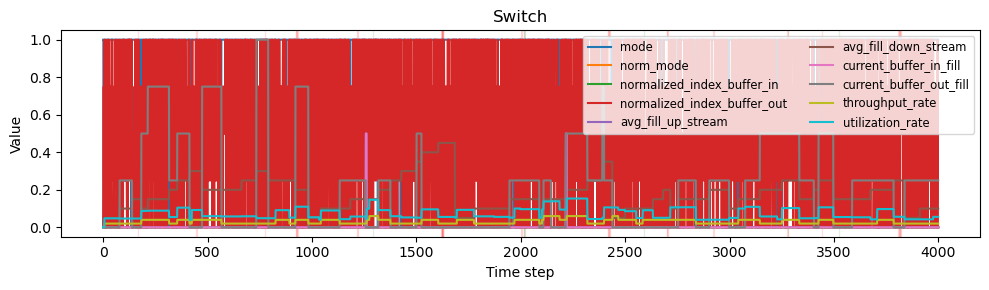

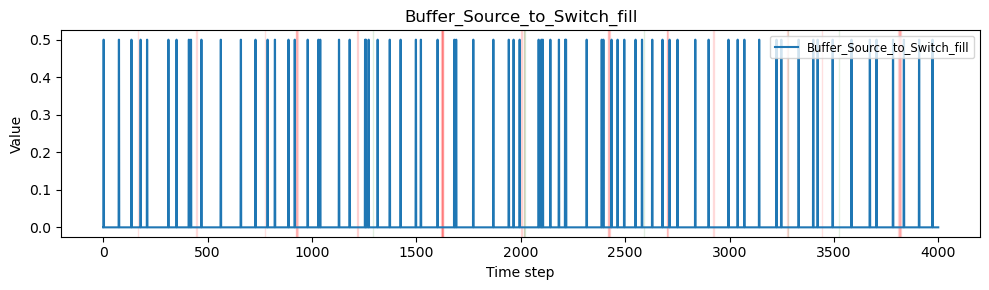

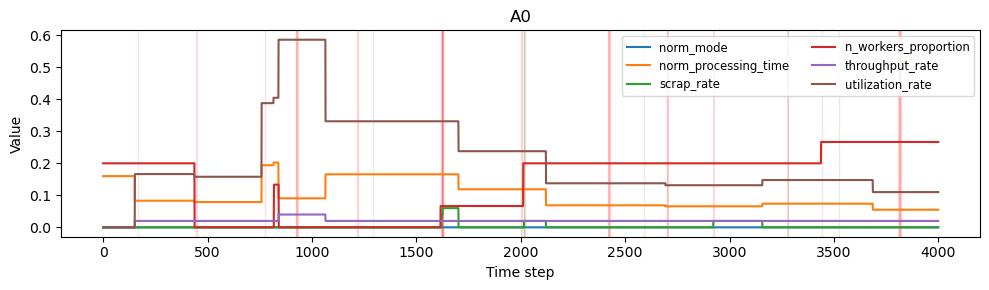

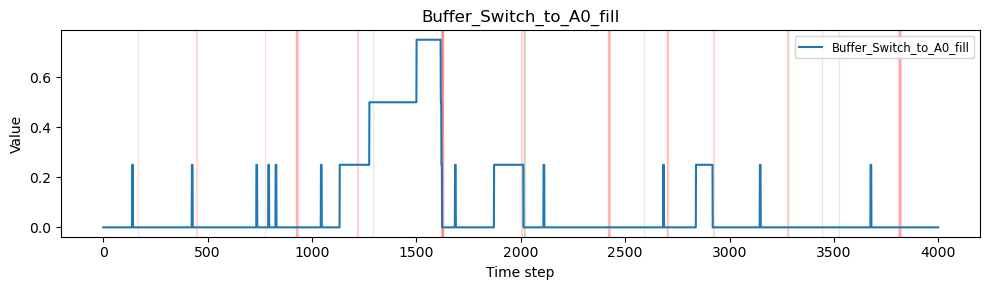

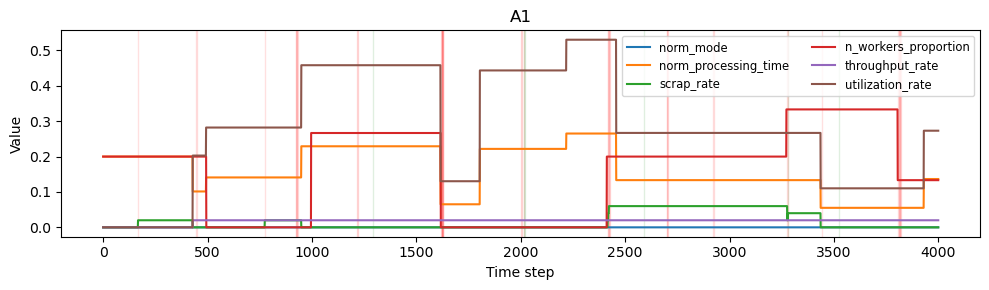

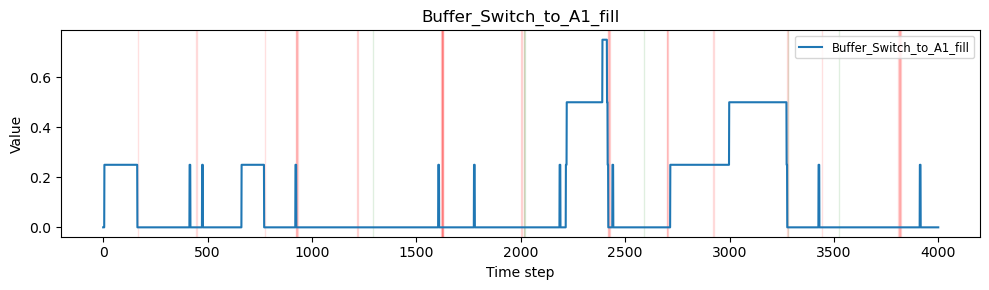

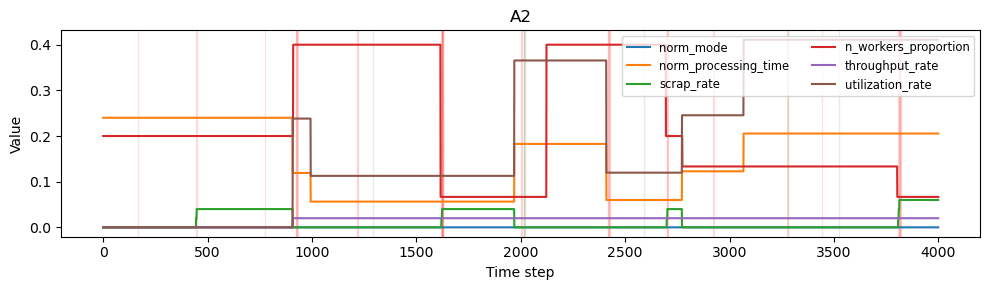

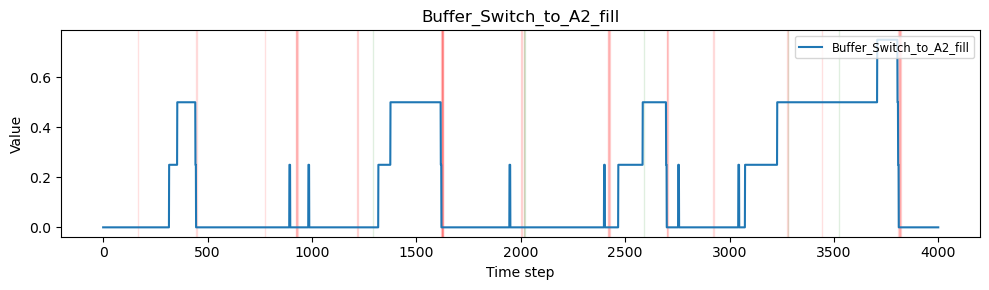

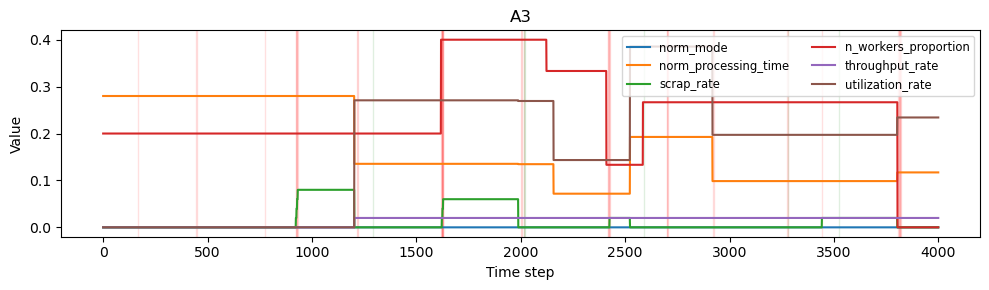

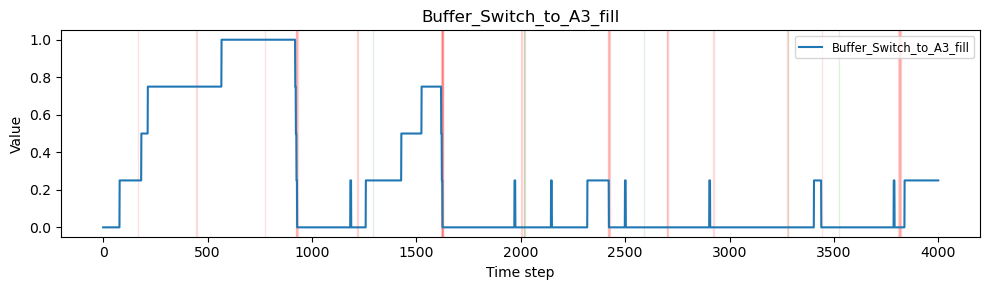

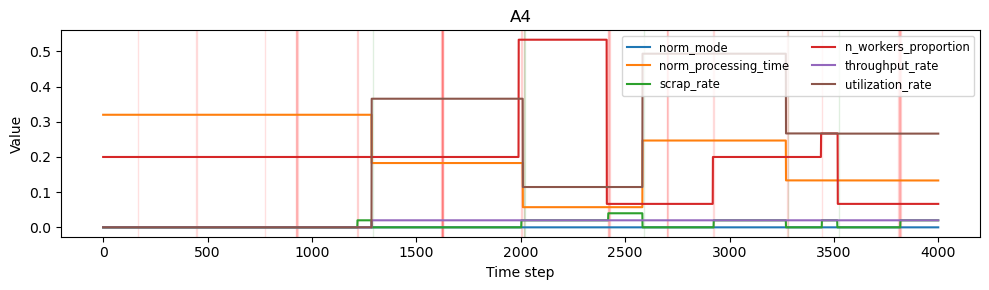

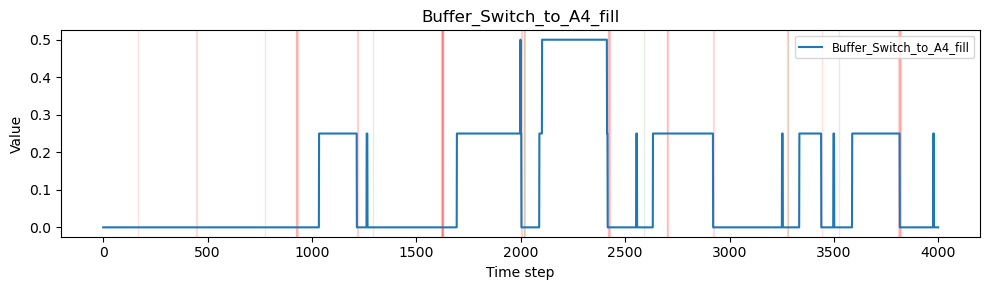

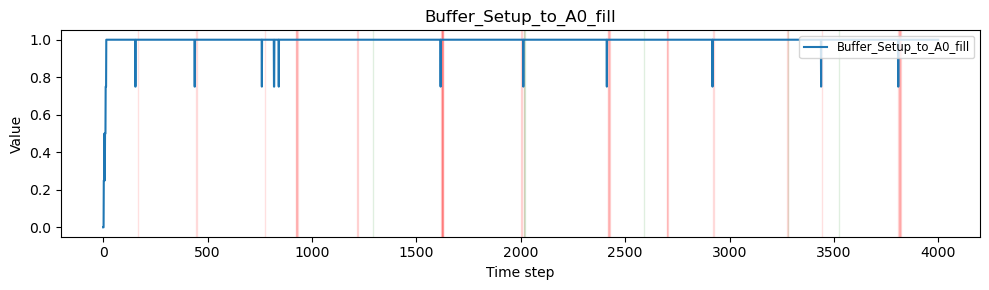

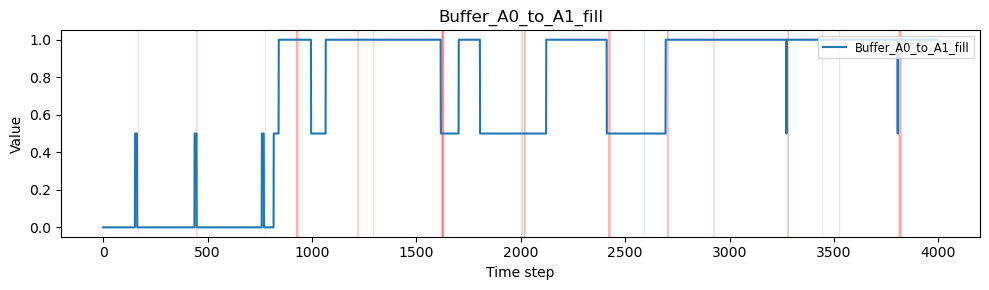

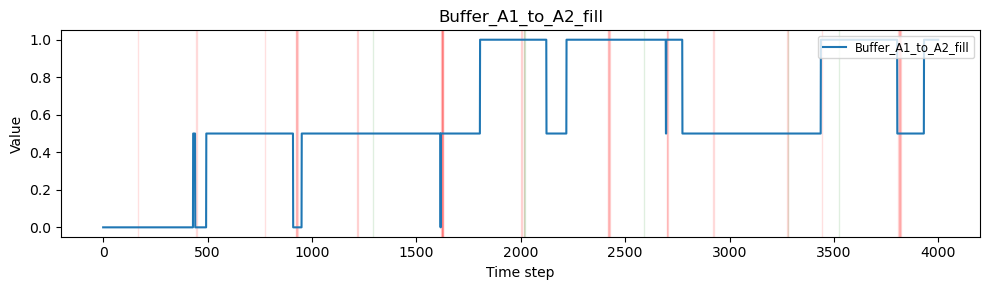

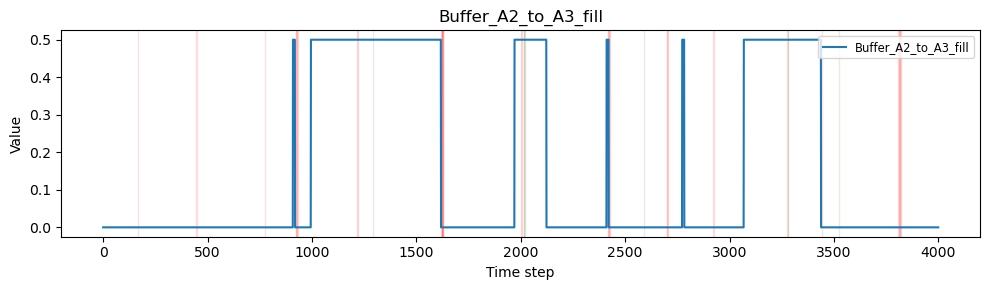

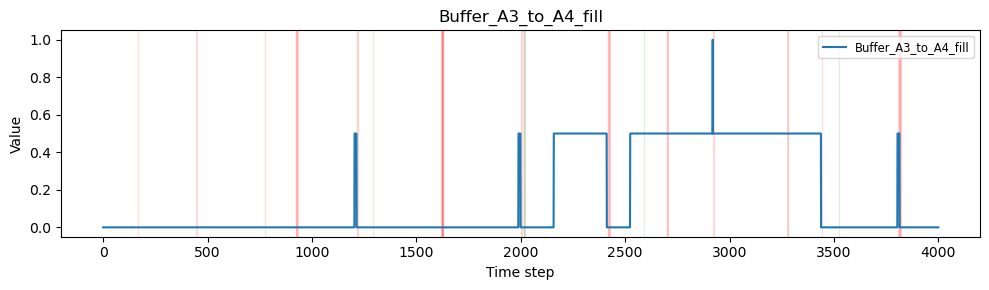

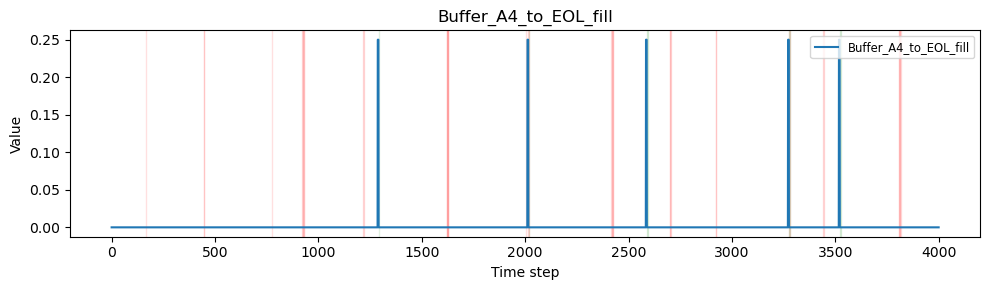

In [4]:
import os

# Group state dimensions by station and plot each station's variables together
# Monkey-patch plt.plot to add reward-colored background (green=positive, red=negative, white=zero)
# Directory to save plots
plots_dir = "plots_complex_line_rand"
os.makedirs(plots_dir, exist_ok=True)

# Counter for filenames
_plot_save_idx = 0

# Save-on-show monkey patch
_orig_show = plt.show
def _show_and_save(*args, **kwargs):
    global _plot_save_idx
    fig = plt.gcf()
    fig.savefig(os.path.join(plots_dir, f"plot_{_plot_save_idx:03d}.png"),
                dpi=150, bbox_inches='tight')
    _plot_save_idx += 1
    return _orig_show(*args, **kwargs)
plt.show = _show_and_save

# Keep original plot (used later in custom wrapper)
_orig_plot = plt.plot

def _plot_with_reward_background(*args, **kwargs):
    ax = plt.gca()
    if not hasattr(ax, '_reward_background_done'):
        rewards_arr = np.asarray(rewards)
        n_steps = len(rewards_arr)
        for t, r in enumerate(rewards_arr):
            if r > 0:
                ax.axvspan(t - 0.5, t + 0.5, color='green', alpha=0.12, zorder=0)
            elif r < 0:
                ax.axvspan(t - 0.5, t + 0.5, color='red', alpha=0.12, zorder=0)
        ax._reward_background_done = True
    return _orig_plot(*args, **kwargs)

plt.plot = _plot_with_reward_background
station_indices = {}
states_arr = np.array(all_states)
for idx, n in enumerate(state_names):
    if n.startswith('Buffer_'):
        station = n  # each buffer on its own (single metric)
    else:
        parts = n.split('_')
        if parts[0] == 'S' and len(parts) > 1:
            station = '_'.join(parts[:2])  # S_main, S_component
        else:
            station = parts[0]  # Assembly, Sink
    station_indices.setdefault(station, []).append((idx, n))

for station, items in station_indices.items():
    plt.figure(figsize=(10, 3))
    for idx, full_name in items:
        label = full_name if station == full_name else full_name[len(station)+1:]
        plt.plot(states_arr[:, idx], label=label)
    plt.title(station)
    plt.xlabel('Time step')
    plt.ylabel('Value')
    plt.legend(loc='upper right', fontsize='small', ncol=2)
    plt.tight_layout()
    plt.show()

